# Recurrent Neural Networks - N-Step Prediction
We turn to the n-step prediction of numerical values, or the forecasting of time series for a given time horizon.
The data for this notebook is the known zick-zack pattern, however this time the model is expected to complete the pattern of the sequence for a fixed amount of future time steps called the 'horizon'. Lets see some examples!

In [1]:
from data_generation import generate_longterm_data
import torch
import torch.nn as nn
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pipeline import train, plot_losses, TrainingStats, evaluate, AfterEpochCallbackParams
from dataclasses import dataclass
from models import Base_RNN, LSTM_RNN, GRU_RNN

RETRAIN_MODELS = False

RANDOM_SEED = 42
# Generate Data
NUM_SEQ = 1000
HORIZON=20
data_set, labels = generate_longterm_data(NUM_SEQ, variable_steps=False, noise=True, horizon=HORIZON)

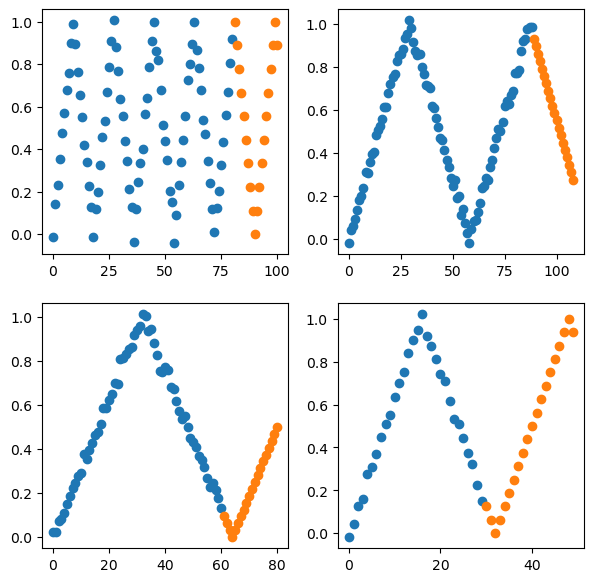

In [2]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
for i, (data, label) in enumerate(zip(data_set[:4], labels[:4])):
    row_idx = i % 2
    col_idx = int(i / 2)
    axs[col_idx][row_idx].plot(data, "o")
    axs[col_idx][row_idx].plot(range(len(data), len(data)+len(label)), label, "o")

As you can see, the data again resembles the known pattern. The input data (in blue) also contains noise again, the label points (in orange) contain the true points of the pattern, without noise. 

---

## Data Exploration

In [3]:
# TODO (exploration):
# - stats (mean, median, std, min, max)
# - sequence lengths
# - label lengths
# - 

print(f"Anzahl Sequencen: {len(data_set)}")
print(f"Anzahl Labels: {len(labels)}")

sequence_lengths = {len(x) for x in data_set}
label_lengths = {len(x) for x in labels}

print(f"Sequenz Längen sind im Bereich von {min(sequence_lengths)} bis {max(sequence_lengths)}")
print(f"Die labels sind {label_lengths} Einträge lang")

Anzahl Sequencen: 1000
Anzahl Labels: 1000
Sequenz Längen sind im Bereich von 12 bis 100
Die labels sind {20} Einträge lang


In [4]:
print(f"Durchnitt Sequence Values: {np.mean([np.mean(x) for x in data_set]):.2f}")
print(f"Durchnitt Label Values: {np.mean([np.mean(x) for x in labels]):.2f}")

print(f"Durchnittliche Std der Sequence Values: {np.mean([np.std(x) for x in data_set]):.2f}")
print(f"Durchnittliche Std der Label Values: {np.mean([np.std(x) for x in labels]):.2f}")

print(f"Maximum der Sequence Values: {np.max([np.max(x) for x in data_set]):.2f}")
print(f"Maximum der Label Values: {np.max([np.max(x) for x in labels]):.2f}")

print(f"Minimum der Sequence Values: {np.min([np.min(x) for x in data_set]):.2f}")
print(f"Minimum der Label Values: {np.min([np.min(x) for x in labels]):.2f}")

Durchnitt Sequence Values: 0.47
Durchnitt Label Values: 0.52
Durchnittliche Std der Sequence Values: 0.27
Durchnittliche Std der Label Values: 0.18
Maximum der Sequence Values: 1.06
Maximum der Label Values: 1.00
Minimum der Sequence Values: -0.07
Minimum der Label Values: 0.00


Wir haben 1000 Sequencen, mit jeweils unterschiedlicher Länge. Darauf folgen immer 20 labels. Die Label Werte sind im Bereich 0 bis 1. Die Sequenzen auch großteils, es kann jedoch vereinzelnt Werte geben, die leicht größer als 1 und leicht kleiner als 0 sind.

Wie in den Plots ersichtlich ist, sind die lables die Fortsetzung der Sequence, die es nun gilt mit einem RNN vorherzusagen.

## Dumb Baselines

Hier sind ein paar sehr einfache (und dumme) Modelle, die unser RNN schlagen sollte:

1. Ein Modell, das immer den Mittelwert unserer Zielwerte vorhersagt.
2. Ein Modell, das immer den Median unserer Zielwerte vorhersagt.
3. Ein Modell, das immer 0,5 vorhersagt.

In [5]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as sklearn_mse, mean_absolute_error as sklearn_mae

mean_model = DummyRegressor(strategy="mean")
median_model = DummyRegressor(strategy="median")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)
dummy_models = [mean_model, median_model]

for dummy_model in dummy_models:
    print(dummy_model.__class__.__name__)
    dummy_model.fit(X_train, y_train)
    predictions = mean_model.predict(X_test)
    print("MSE Error: ", sklearn_mse(y_test, predictions))
    print("MAE Error: ", sklearn_mae(y_test, predictions))

DummyRegressor
MSE Error:  0.08706528273085812
MAE Error:  0.2567825369619742
DummyRegressor
MSE Error:  0.08706528273085812
MAE Error:  0.2567825369619742


Wir können sehen, dass alle  Modelle nahezu identisch abschneiden (weil der Mittelwert und der Median sehr ähnlich sind).

Wir werden beide Errors ($MAE\approx0.25$ and $MSE\approx0.08$) für den späteren Vergleich mit dem RNN speichern.

In [7]:
# we will use the latest prediction (point_five_model) to initialize the baseline loss values.
BASELINE_MSE_LOSS =  sklearn_mse(y_test, predictions)
BASELINE_MAE_LOSS =  sklearn_mae(y_test, predictions)

## Training Pipeline

Siehe `pipeline.py` für Implementation.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)

In [9]:
import os

LOG_FILE_PATH = "./logs/history"
MODEL_DESCRIPTION = ""

def write_stats_callback(params: AfterEpochCallbackParams):
    model_name = params.model.__class__.__name__
    filepath = f"{LOG_FILE_PATH}/{model_name}-{MODEL_DESCRIPTION}"
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f"{filepath}/training-stats-1.csv", "a+") as f:
        header, content = params.as_csv_string()
        if params.epoch == 1:
            f.write(f"Model Class: {params.model.__class__.__name__} | Hidden Len: {params.model.hidden_len}")
            f.write(header + "\n")
        f.write(content  + "\n")


def save_best_model_callback(params: AfterEpochCallbackParams):
    """Saves a model if the validation loss is at a minimum."""
    min_val_loss = np.min(params.val_loss_history)
    model_name = params.model.__class__.__name__
    if params.current_val_loss <= min_val_loss:
        filepath = f"{LOG_FILE_PATH}/{model_name}-{MODEL_DESCRIPTION}/best-params"
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        torch.save(params.model, f"{filepath}/params_epoch{params.epoch}.pt")

## Model Capacity

Siehe `models.py` für Implementationsdetails.

Bevor wir das Modell auf die ganzen Daten loschicken, wollen wir auf wenige Daten testen, ob unser Modell das Problem überhaupt schaffen kann.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, train_size=0.2, random_state=RANDOM_SEED) # only takes 200 train samples

model = Base_RNN(1,10,1) # Base_RNN model with 1 hidden state of size 10. Input and output size is 1
mse_loss = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(), lr=3e-4)
if RETRAIN_MODELS:
    train_result = train(model, 200, X_train, y_train, mse_loss, adam, post_epoch_callbacks=[write_stats_callback])
    #torch.save(model, "./models/base/demonstrate_capacity.pt")
else:
    model = torch.load("./models/base/demonstrate_capacity.pt")

Wir sehen, in der Grafik, dass selbst bei 200 Datensätzen und einem Hidden State mit Länge 10 der Loss bereits kleiner ist als unsere Dumb baselines, aber wie sieht das grafisch aus?

MSE Loss:  0.06517604


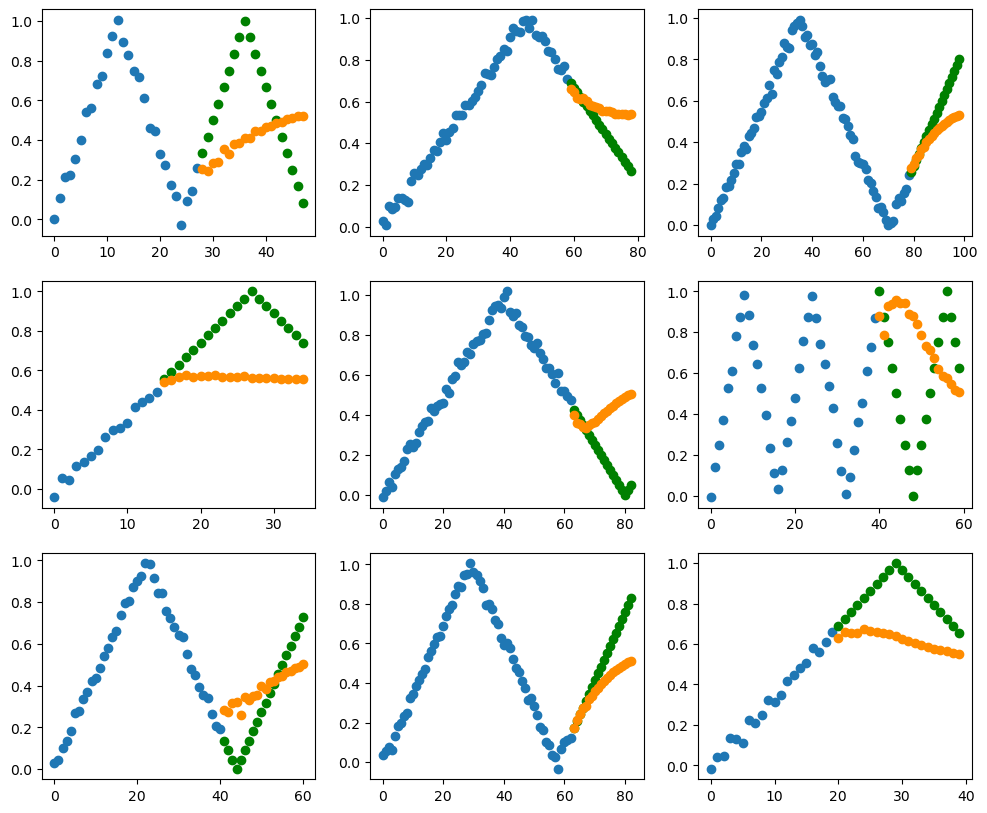

In [11]:
mean_loss, _ = evaluate(model, X_test, y_test, visualize_oneline=False, visualize_start_idx=4) 
print("MSE Loss: ", mean_loss)

Hier kann man grafisch definitiv eine Verbesserung zu den Dumb Baselines erkennen. Unser Model kann bei manchen Datensätzen die aufgabe lösen. Wir müssen das Ergebnis jedoch weiterhin mit Hilfe von Hyperparameter Tuning oder Model Improvements (GRU, LSTM) verbessern.

# Looking for the best model 

Nachdem wir gezeigt haben, dass unser Model den Task bereits ansatzweise lösen kann, gilt es nun an den Hyperparametern zu drehen.

In diesem Abschnitt werden wir alle 1000 Datensätze verwenden (800 Train / 200 Test) und versuchen mittels Hyperparameter Tuning ein gutes Resultat zu erhalten.

## Basic RNN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)

# Beginnen wir mit einem Basic RNN und 30 Hidden Length, mit 250 Epochen
basic_model = Base_RNN(1,30,1)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
adam = torch.optim.Adam(basic_model.parameters(), lr=3e-4)
EPOCHS = 250

model_path = f"./models/base/base_rnn_30-hidden_250-epochs.pt"

if RETRAIN_MODELS:
    train_result = train(basic_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam, post_epoch_callbacks=[write_stats_callback])
    torch.save(basic_model, model_path)
else:
    try: 
        basic_model = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")


(0.0027901756, 0.001339724)

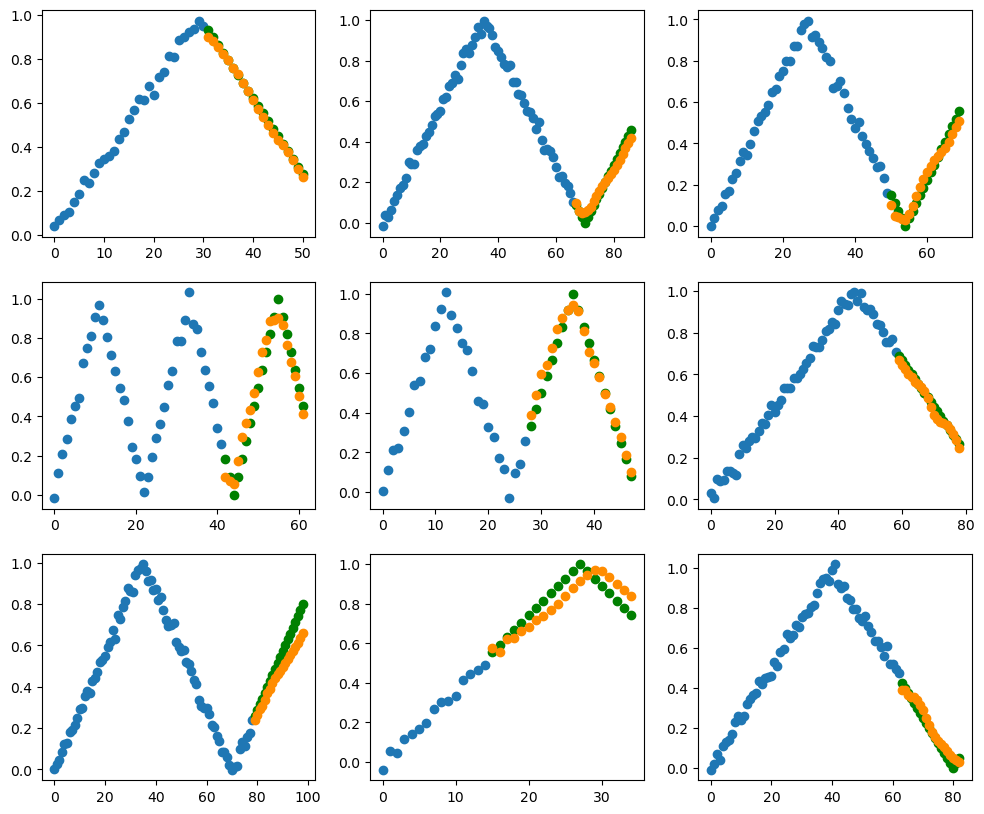

In [13]:
evaluate(basic_model, X_test, y_test)

Ein normales RNN schafft es mit ausreichend Training sehr gut das Problem zu lösen. Die Zacken sind teilweise noch nicht ganz sauber, aber der Rest sieht sehr gut aus.

## GRU Model

In [14]:
gru_model = GRU_RNN(1,30,1)
adam_gru = torch.optim.Adam(gru_model.parameters(), lr=3e-4)
model_path = "./models/gru/gru_30-hidden_250-epochs.pt"


if RETRAIN_MODELS:
    gru_training_stats = train(gru_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam_gru, post_epoch_callbacks=[write_stats_callback])
    torch.save(model, model_path)
else:
    try: 
        gru_model = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")


(0.0006970821, 0.00031072)

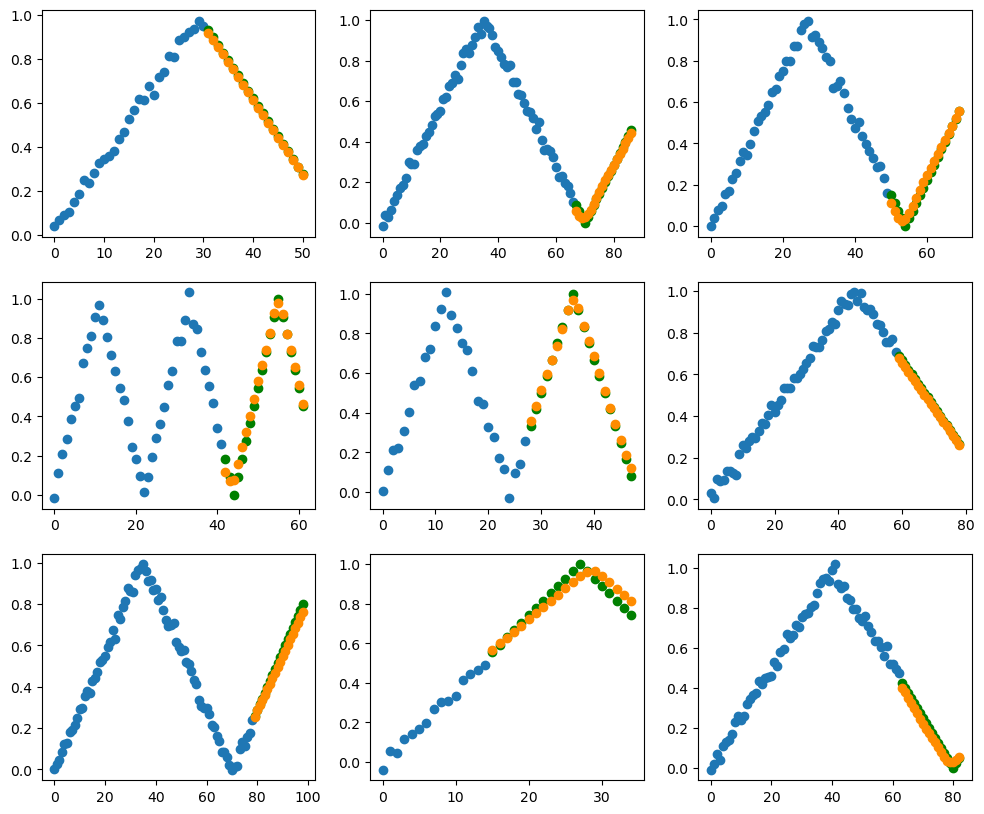

In [15]:
evaluate(gru_model, X_test, y_test)

Noch besser sieht es bei einem GRU Modell aus. Hier mann man erkennen dass selbst die Zacken sehr ausführlich vorhergesagt werden.

## LSTM Model

In [16]:
lstm_model = LSTM_RNN(1,30,1)
adam_lstm = torch.optim.Adam(lstm_model.parameters(), lr=3e-4)

model_path = "./models/lstm/lstm_30-hidden_250_epochs.pt"

if RETRAIN_MODELS:
    lstm_training_stats = train(lstm_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam_gru, post_epoch_callbacks=[write_stats_callback])
    torch.save(model, model_path)
else:
    try: 
        lstm_model = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")


(0.0006830098, 0.00044047987)

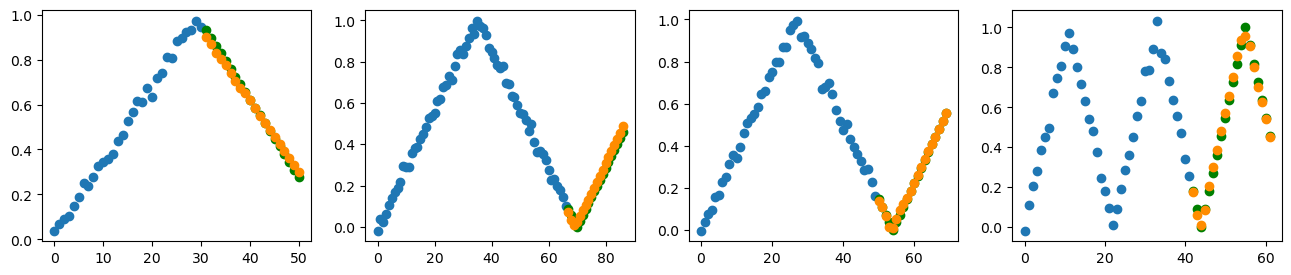

In [17]:
evaluate(lstm_model, X_test, y_test, visualize_oneline=True)

LSTM ist ebenfalls sehr gut. Grafisch erkenne ich keinen Unterschied, der Loss ist aber bei GRU leicht geringer. Außerdem hat das LSTM Modell aufgrund der vielen Parameter wesentlich länger trainiert.

## Conclusion

Zwischen GRU und LSTM ist kaum ein Unterschied zu erkennen. Da das GRU jedoch wesentlich geringere Trainingszeit (und sogar minimal besser abschneidet), werde ich folgendes Modell als bestes deklarieren:

GRU Modell, mit Hyperparametern:
- 250 Trainingsepochen
- Adam Optimizer, Learning Rate=3e-4
- Loss: Mean Squared Error
- Hidden Layer Size = 30

Dieses Modell werde ich nun heranziehen, um zu testen, wie viele Trainingsdaten notwendig sind, um das Problem zu lösen.

# Wie viele Daten sind notwendig?

In diesem Abschnitt geht es darum, das Minimum an Trainingsdaten zu finden, bei dem das Problem weiterhin gut gelöst wird.

Aus den obigen Abschnitt kann man gut erkennen, dass 800 Trainingsdaten ausreichen um das Problem zu lösen. Das beste Modell erzieehlte auf die 200 Testdaten ein Mean Squared Loss von <0.001 erziehlt. Auch grafisch sieht das Ergebnis sehr gut aus. Mehr als 800 Trainingsdaten werden also auf jeden Fall nicht benötigt.

Frage: Wie viele Trainingsdaten sind notwendig, damit dieses Modell das Problem lösen kann?

Wir werden nun mehrere Daten probieren, angefangen mit 200 Trainingsdaten.

In [18]:
model_200 = GRU_RNN(1,30,1)
EPOCHS=250
LEARNING_RATE=3e-4
loss=nn.MSELoss()
optimizer = torch.optim.Adam(model_200.parameters(), lr=LEARNING_RATE)
model_path = "./models/less_data/gru_200.pt"
if RETRAIN_MODELS:
    gru_200_training_stats = train(model_200, EPOCHS, X_train[:200], y_train[:200], loss_f=mae_loss, optimizer=optimizer, post_epoch_callbacks=[write_stats_callback])
    torch.save(model_200, model_path)
else:
    try: 
        model_200 = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")

(0.001933687, 0.0008565629)

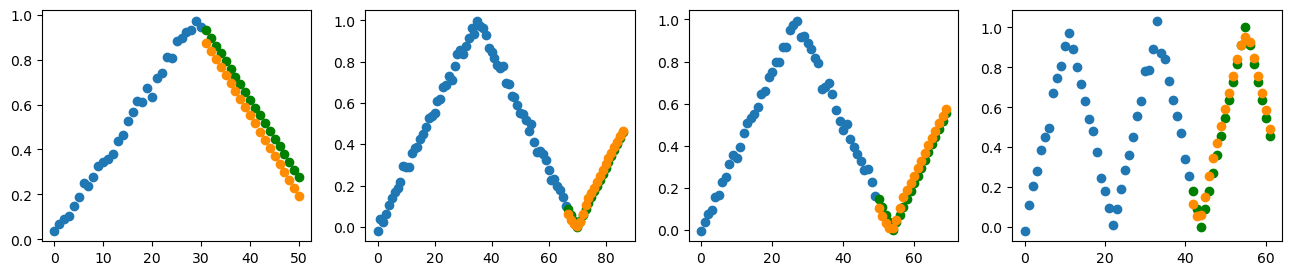

In [19]:
evaluate(model_200, X_test, y_test, visualize_oneline=True) # 200 epochs

Sehr gut, 200 Datenpunkte können auch reichen.

Probieren wirs mit 50

In [20]:
model_100 = GRU_RNN(1,30,1)
EPOCHS=250
LEARNING_RATE=3e-4
loss=nn.MSELoss()
optimizer = torch.optim.Adam(model_100.parameters(), lr=LEARNING_RATE)
model_path = "./models/less_data/gru_100.pt"

if RETRAIN_MODELS:
    model_100_training = train(model_100, EPOCHS, X_train[:100], y_train[:100], loss_f=mae_loss, optimizer=optimizer, post_epoch_callbacks=[write_stats_callback])
    torch.save(model_100, model_path)
else:
    try: 
        model_100 = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")

(0.01847047, 0.0056008054)

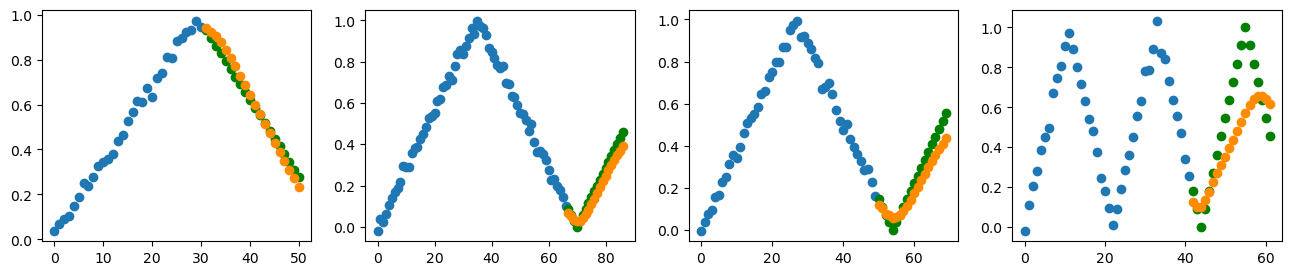

In [21]:
evaluate(model_100, X_test, y_test, visualize_oneline=True)

Immernoch erstaunlich gut! Probieren wir 50?

In [22]:
from models import GRU_RNN
import torch.nn as nn
import torch
from pipeline import train

model_50 = GRU_RNN(1,30,1)
EPOCHS=250
LEARNING_RATE=3e-4
loss=nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr=LEARNING_RATE)
model_path = "./models/less_data/gru_50.pt"

if RETRAIN_MODELS:
    model_50_training = train(model_50, EPOCHS, X_train[:50], y_train[:50], loss_f=mae_loss, optimizer=optimizer, post_epoch_callbacks=[write_stats_callback])
    torch.save(model_50, model_path)
else:
    try: 
        model_50 = torch.load(model_path)
    except:
        print(f"Model does not exist at location: {model_path}")

(0.051885344, 0.019170944)

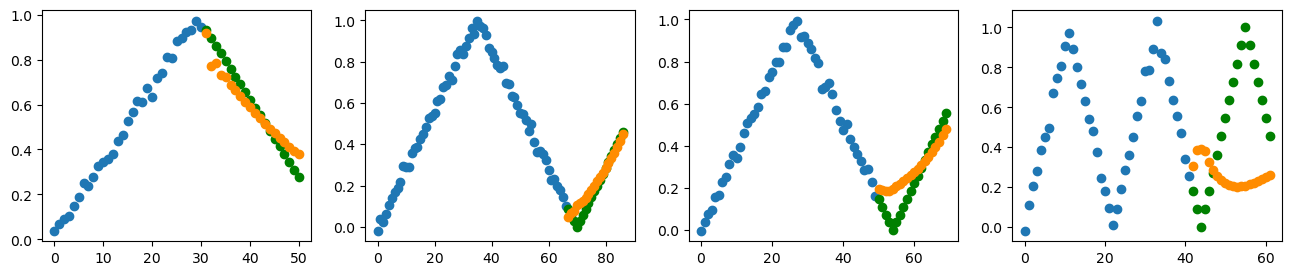

In [23]:
evaluate(model_50, X_test, y_test, visualize_oneline=True)

Deutlich schlechter. Um das Problem einigermaßen gut zu lösen sollte mit mindestens die 90 Datensätzen trainiert werden. (10% der Daten werden defaultmäßig als Validation Set verwendet und nicht zum trainieren).

Dennoch lässt sich anhand der Beispiele zeigen, dass mehr Trainingsdaten auch zu besseren Resultaten führen.

## Visualisierung der Models

Model Name | L1Loss
Best GRU: 0.01919
Best LSTM: 0.02021
Best 'standard' RNN: 0.03915
GRU_200: 0.03314
GRU_100: 0.08711
GRU_50: 0.16126


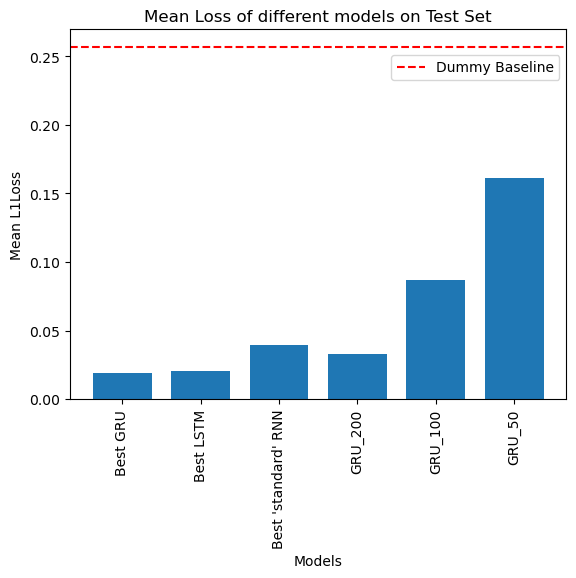

In [27]:
from pipeline import compare_models

models = [
    ("Best GRU", gru_model),
    ("Best LSTM", lstm_model),
    ("Best 'standard' RNN", basic_model),
    ("GRU_200", model_200),
    ("GRU_100", model_100),
    ("GRU_50", model_50),
]

compare_models(models, X_test, y_test, baseline=BASELINE_MAE_LOSS, loss_fn=torch.nn.L1Loss())